In [2]:
import matplotlib, time
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from numpy import pi, sqrt, ceil, array, sin, cos, tan, arctan, tanh, log, exp
from scipy import optimize
from math import erf
from qutip import (Qobj, tensor, basis, fock, ket, bra, num, qeye, destroy, fidelity, expect, ket2dm, mesolve, 
                   identity, sigmax, sigmay, sigmaz, Options, mcsolve
                  )
from qutip.visualization import plot_fock_distribution, matrix_histogram
                  
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
matplotlib.rcParams['xtick.direction'] = 'in'  
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(suppress=True)
from qutip.visualization import hinton
import math as math
# important settings to improve ODE solver
options = Options()
options.num_cpus=24
options.atol = 1e-12
options.rtol = 1e-10
options.order = 40
options.nsteps = 20000
import cython
import random

# two dual rail qubit gate: using qubit-manipulate sideband, M1-S1 and M2-S3 pair would be ideal

# set up the system

In [24]:
def QMSS_system(tlist, t0, psi0, driving_param, device):

    # Q, M1, M2, S2, S3: M1-S2, M2-S4
    # curoff photon number
    N_q, N_m, N_s = device['N_q'], device['N_m'], device['N_s']
    # wq, wm, ws1, ws2 = device['wq'], device['wm'], device['ws1'], device['ws2']
    # alpha = device['alpha']

    zz_qm1, zz_qm2, zz_m1m2= device['zz_qm1'], device['zz_qm2'], device['zz_m1m2']
    zz_m1s2, zz_m1s4= device['zz_m1s2'], device['zz_m1s4']
    zz_m2s2, zz_m2s4= device['zz_m2s2'], device['zz_m2s4']
    zz_s2s4= device['zz_s2s4']

    # driving is always constant pulses

    A_ge, A_ge_y, A_ef = driving_param['A_ge'], driving_param['A_ge_y'], driving_param['A_ef']
    A_f0g1_m1, A_f0g1_m2 = driving_param['A_f0g1_m1'], driving_param['A_f0g1_m2']
    A_m1s2, A_m2s4 = driving_param['A_m1s2'], driving_param['A_m2s4']

    # coherence
    T1_q, T1_m1, T1_m2, T1_s2, T1_s4 = device['T1_q'],device['T1_m1'],device['T1_m2'],device['T1_s2'],device['T1_s4']
    T2_q, T2_m1, T2_m2, T2_s2, T2_s4 = device['T2_q'],device['T2_m1'],device['T2_m2'],device['T2_s2'],device['T2_s4']

    ## define driving operators
    a_q = tensor(destroy(N_q),qeye(N_m),qeye(N_m),qeye(N_s),qeye(N_s))
    a_m1 = tensor(qeye(N_q),destroy(N_m),qeye(N_m),qeye(N_s),qeye(N_s)) 
    a_m2 = tensor(qeye(N_q),qeye(N_m),destroy(N_m),qeye(N_s),qeye(N_s))
    a_s2 = tensor(qeye(N_q),qeye(N_m),qeye(N_m),destroy(N_s),qeye(N_s))
    a_s4 = tensor(qeye(N_q),qeye(N_m),qeye(N_m),qeye(N_s),destroy(N_s))

    op_ge = tensor(ket("1", N_q)*bra("0", N_q)+ket("0", N_q)*bra("1", N_q),qeye(N_m),qeye(N_m),qeye(N_s),qeye(N_s))  #coeff is 1/pi_lenght/2/pi
    op_ge_y = tensor(1j*ket("1", N_q)*bra("0", N_q)-1j*ket("0", N_q)*bra("1", N_q),qeye(N_m),qeye(N_m),qeye(N_s),qeye(N_s))  #coeff is 1/pi_lenght/2/pi
    op_ef = tensor(ket("1", N_q)*bra("2", N_q)+ket("2", N_q)*bra("1", N_q),qeye(N_m),qeye(N_m),qeye(N_s),qeye(N_s))  #coeff is 1/pi_lenght/2/pi
    op_f0g1_1 = a_q.dag()*a_q.dag()*a_m1+a_q*a_q*a_m1.dag()   #coeff is 1/pi_lenght/2/pi/sqrt(2)
    op_f0g1_2 = a_q.dag()*a_q.dag()*a_m2+a_q*a_q*a_m2.dag()   #coeff is 1/pi_lenght/2/pi/sqrt(2)
    op_m1s2 = a_m1.dag()*a_s2+a_m1*a_s2.dag()  # coeff is 1/pi_lenght/2/pi
    op_m2s4 = a_m2.dag()*a_s4+a_m2*a_s4.dag()   #coeff is 1/pi_lenght/2/pi

    # system static hamiltonan (ZZ part)
    H_0 = zz_qm1*a_q.dag()*a_q*a_m1.dag()*a_m1 + zz_qm2*a_q.dag()*a_q*a_m2.dag()*a_m2 + zz_m1m2*a_m1.dag()*a_m1*a_m2.dag()*a_m2
    H_0 += zz_m1s2*a_m1.dag()*a_m1*a_s2.dag()*a_s2+zz_m1s4*a_m1.dag()*a_m1*a_s4.dag()*a_s4
    H_0 += zz_m2s2*a_m2.dag()*a_m2*a_s2.dag()*a_s2+zz_m2s4*a_m2.dag()*a_m2*a_s4.dag()*a_s4
    H_0 += zz_s2s4*a_s2.dag()*a_s2*a_s4.dag()*a_s4

    # print(H_0)


    # dynamical part:

    H_ge = A_ge*op_ge
    H_ge_y = A_ge_y*op_ge_y
    H_ef = A_ef*op_ef
    H_f0g1_1 = A_f0g1_m1*op_f0g1_1
    H_f0g1_2 = A_f0g1_m2*op_f0g1_2
    H_m1s2 = A_m1s2*op_m1s2
    H_m2s4 = A_m2s4*op_m2s4
    # print(H_ge)
    # print(H_ef)
    # print(H_f0g1)
    # print(H_m1s1)
    # print(H_m1s2)


    c_ops = []
    Ht = H_0+H_ge+H_ge_y+H_ef+H_f0g1_1+H_f0g1_2+H_m1s2+H_m2s4

    Gamma_q = 0
    Gamma_m1 = 0
    Gamma_m2 = 0
    Gamma_s2 = 0
    Gamma_s4 = 0

    Gamma_phi_q = 0
    Gamma_phi_m1 = 0
    Gamma_phi_m2 = 0
    Gamma_phi_s2 = 0
    Gamma_phi_s4 = 0

    if T1_q>0:
        Gamma_q = 1/T1_q
    if T1_m1>0:
        Gamma_m1 = 1/T1_m1
    if T1_m2>0:
        Gamma_m2 = 1/T1_m2
    if T1_s2 > 0:
        Gamma_s2 = 1/T1_s2
    if T1_s4 > 0:
        Gamma_s4 = 1/T1_s4
    
    c_ops = []
    if Gamma_q > 0:
        c_ops.append(np.sqrt(Gamma_q) * a_q)
    if Gamma_phi_q > 0:
        c_ops.append(np.sqrt(Gamma_phi_q) * a_q.dag()*a_q)
    if Gamma_m1 > 0:
        c_ops.append(np.sqrt(Gamma_m1) * a_m1)
    if Gamma_phi_m1 > 0:
        c_ops.append(np.sqrt(Gamma_phi_m1) * a_m1.dag()*a_m1)
    if Gamma_m2 > 0:
        c_ops.append(np.sqrt(Gamma_m2) * a_m2)
    if Gamma_phi_m2 > 0:
        c_ops.append(np.sqrt(Gamma_phi_m2) * a_m2.dag()*a_m2)
    if Gamma_s2 > 0:
        c_ops.append(np.sqrt(Gamma_s2) * a_s2)
    if Gamma_phi_s2 > 0:
        c_ops.append(np.sqrt(Gamma_phi_s2) * a_s2.dag()*a_s2)
    if Gamma_s4 > 0:
        c_ops.append(np.sqrt(Gamma_s4) * a_s4)
    if Gamma_phi_s4 > 0:
        c_ops.append(np.sqrt(Gamma_phi_s4) * a_s4.dag()*a_s4)


    # print('Running mesolve...')
    args = {}
    result = mesolve(Ht, psi0, tlist+t0, c_ops, [], args, options=options)

    tend = tlist[-1]+t0
    psi1 = result.states[-1]


    return psi1, tend, result

# Device definition

In [208]:
device = {}
driving_param = {}
gate_length = {}

device['N_q'], device['N_m'], device['N_s'] = 4, 3, 3

device['zz_qm1'], device['zz_qm2'], device['zz_m1m2'] = -0.285*2*np.pi, -0.272*2*np.pi*0, -0.01*2*np.pi*0
device['zz_m1s2'], device['zz_m1s4'] = -0.001838*2*np.pi*0, -0.001344*2*np.pi*0
device['zz_m2s2'], device['zz_m2s4'] = -0.001838*2*np.pi*0, -0.001344*2*np.pi *0  # need to measure
device['zz_s2s4'] = -0.0002*2*np.pi*0  # need verify
device['T1_q'],device['T1_m1'],device['T1_m2'],device['T1_s2'],device['T1_s4'] = 490*0, 210*0, 120*0, 1254*0, 595*0
device['T2_q'],device['T2_m1'],device['T2_m2'],device['T2_s2'],device['T2_s4'] = 259, 75.5, 77, 460, 770

ge_length = 0.035*4
ef_length = 0.035*4
sync = 0.01
m1_f0g1_length = 0.615287 + 0.005*6
m2_f0g1_length = 1.060413 + 0.005*6
m1s2_length = 1.055448 + 0.005*6
m2s4_length = 1.185166 + 0.005*6

gate_length['ge_length'] = ge_length
gate_length['ef_length'] = ef_length
gate_length['sync'] = sync
gate_length['m1_f0g1_length'] = m1_f0g1_length
gate_length['m2_f0g1_length'] = m2_f0g1_length
gate_length['m2s4_length'] = m2s4_length
gate_length['m1s2_length'] = m1s2_length

driving_param['A_ge'] = 1/ge_length/2*np.pi   /2 *0
driving_param['A_ge_y'] = 1/ge_length/2*np.pi   /2 *0
driving_param['A_ef'] = 1/ef_length/2*np.pi *0 

driving_param['A_f0g1_m1'] = 1/m1_f0g1_length/2*np.pi/np.sqrt(2) *0
driving_param['A_f0g1_m2'] = 1/m2_f0g1_length/2*np.pi/np.sqrt(2) *1
driving_param['A_m2s4'] = 1/m2s4_length/2*np.pi *0
driving_param['A_m1s2'] = 1/m1s2_length/2*np.pi *0

psi0 = tensor(ket("0", device['N_q']), ket("1", device['N_m']), ket("1", device['N_m']), ket("0", device['N_s']), ket("0", device['N_s']))
psi0 = psi0.unit()
tlist = np.linspace(0, m2_f0g1_length, 1001)
psi1, tend, output = QMSS_system(tlist, 0, psi0, driving_param, device)


1.0


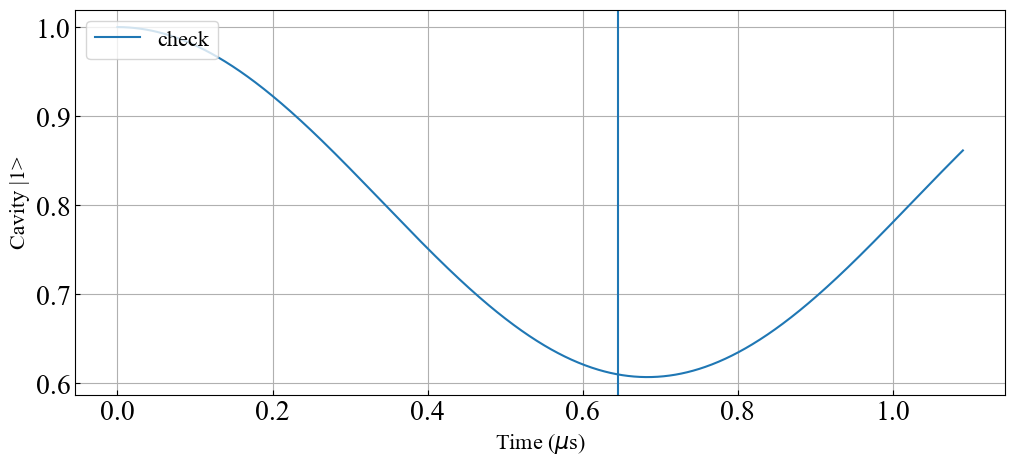

In [209]:
c_photon = tensor(qeye(device['N_q']), qeye(device['N_m']), ket("1",device['N_m'])*bra("1",device['N_m']), qeye(device['N_s']), qeye(device['N_s']))
# c_photon = tensor(qeye(device['N_q']), ket("1",device['N_m'])*bra("1",device['N_m']), qeye(device['N_m']),qeye(device['N_s']), qeye(device['N_s']))
result = []
for ii in output.states:
    result.append(expect(c_photon, ii))
print(max(result))

fig, ax = plt.subplots(1, 1, figsize=(12,5))

ax.plot(tlist, result, label='check')
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel('Cavity |1>')
ax.tick_params(labelsize=20)
plt.axvline(m1_f0g1_length)
plt.legend(fontsize=16, loc=2)
plt.grid()

# CZ gate implementation

In [184]:
# M1-Q, wait, Q-M1
## If Q is in |e>, throw away the data
gg = tensor(ket("0", device['N_q']), ket("0", device['N_m']), ket("0", device['N_m']), ket("1", device['N_s']), ket("1", device['N_s']))
ge = tensor(ket("0", device['N_q']), ket("0", device['N_m']), ket("1", device['N_m']), ket("1", device['N_s']), ket("0", device['N_s']))
eg = tensor(ket("0", device['N_q']), ket("1", device['N_m']), ket("0", device['N_m']), ket("0", device['N_s']), ket("1", device['N_s']))
ee = tensor(ket("0", device['N_q']), ket("1", device['N_m']), ket("1", device['N_m']), ket("0", device['N_s']), ket("0", device['N_s']))
psi0 = gg+ge+eg+ee
psi0 = ee
psi0 = psi0.unit()

# ZZ waiting time:
t_cz = abs(1/device['zz_qm2']/2)
t_cz=0.001
# t_cz = 0.9

#==== M1-Q#===#

driving_param['A_f0g1_m1'] = 1/m1_f0g1_length/2*np.pi/np.sqrt(2)
tlist = np.linspace(0, gate_length['m1_f0g1_length'], 501)
psi1, tnow, output = QMSS_system(tlist, 0, psi0, driving_param, device)
# driving_param['A_f0g1_m1'] = 1/m1_f0g1_length/2*np.pi/np.sqrt(2) *0 

# # #=== idling period ====

# tlist = np.linspace(0, t_cz, 501)
# psi2, tnow, output = QMSS_system(tlist, tnow, psi1.unit(), driving_param, device)


# # #===== Q-M1 -----

# driving_param['A_f0g1_m1'] = 1/m1_f0g1_length/2*np.pi/np.sqrt(2)*0
# tlist = np.linspace(0, gate_length['m1_f0g1_length'], 501)
# psi3, tnow, output = QMSS_system(tlist, tnow, psi2.unit(), driving_param, device)
# driving_param['A_f0g1_m1'] = 1/m1_f0g1_length/2*np.pi/np.sqrt(2) *0 


# check final state


In [187]:
driving_param

{'A_ge': 0.0,
 'A_ge_y': 0.0,
 'A_ef': 0.0,
 'A_f0g1_m1': 1.721281746788005,
 'A_f0g1_m2': 0.0,
 'A_m2s4': 0.0,
 'A_m1s2': 0.0}

In [185]:
print('gg: ',expect(ket2dm(gg),psi0))
print('ge: ',expect(ket2dm(ge),psi0))
print('eg: ',expect(ket2dm(eg),psi0))
print('ee: ',expect(ket2dm(ee),psi0))

gg:  0.0
ge:  0.0
eg:  0.0
ee:  1.0


In [186]:
print('gg: ',expect(ket2dm(gg),psi1))
print('ge: ',expect(ket2dm(ge),psi1))
print('eg: ',expect(ket2dm(eg),psi1))
print('ee: ',expect(ket2dm(ee),psi1))

gg:  0.0
ge:  0.0
eg:  0.0
ee:  0.4082662960485032


In [168]:
print('gg: ',expect(ket2dm(gg),psi2))
print('ge: ',expect(ket2dm(ge),psi2))
print('eg: ',expect(ket2dm(eg),psi2))
print('ee: ',expect(ket2dm(ee),psi2))

gg:  0.2500000396135914
ge:  0.2500000396135914
eg:  4.774831552460917e-18
ee:  0.10206655793614175


In [169]:
print('gg: ',expect(ket2dm(gg),psi3))
print('ge: ',expect(ket2dm(ge),psi3))
print('eg: ',expect(ket2dm(eg),psi3))
print('ee: ',expect(ket2dm(ee),psi3))

gg:  0.25000007372666544
ge:  0.25000007372666544
eg:  4.774832203997726e-18
ee:  0.10206657186336493


# Simple test of detunedly driven system

In [233]:
def QM_system(tlist, t0, psi0, driving_param, device):

    # Q, M
    # curoff photon number
    N_q, N_m = device['N_q'], device['N_m']


    zz_qm1, alpha = device['zz_qm1'], device['alpha']

    # driving is always constant pulses
    # each drive is described by two parameters, drive strength and detuning from qubit bare g-e frequency

    A_ge = driving_param['A_ge']
    detuning = driving_param['detuning']



    ## define driving operators
    a_q = tensor(destroy(N_q),qeye(N_m))
    a_m = tensor(qeye(N_q),destroy(N_m)) 


    op_ge = tensor(ket("1", N_q)*bra("0", N_q)+ket("0", N_q)*bra("1", N_q),qeye(N_m))  #coeff is 1/pi_lenght/2/pi


    # system static hamiltonan (ZZ part)
    H_0 = zz_qm1*a_q.dag()*a_q*a_m.dag()*a_m+alpha/2*a_q.dag()*a_q.dag()*a_q*a_q

    # dynamical part:
    def fff(t, args):
        return np.exp(1j*args['det']*t)
    def ffg(t, args):
        return np.exp(-1j*args['det']*t)

    H_t = [H_0, [A_ge*a_q, fff], [A_ge*a_q.dag(), ffg]]


    c_ops = []



    # print('Running mesolve...')
    args = {'det': detuning}
    result = mesolve(H_t, psi0, tlist+t0, c_ops, [], args, options=options)

    tend = tlist[-1]+t0
    psi1 = result.states[-1]


    return psi1, tend, result

In [276]:
device = {}
driving_param = {}
gate_length = {}

device['N_q'], device['N_m'] = 4, 3

device['zz_qm1'] = -0.285*2*np.pi
device['alpha'] = -150*2*np.pi


ge_length = 0.5


gate_length['ge_length'] = ge_length


driving_param['A_ge'] = 1/ge_length/2*np.pi /2
driving_param['detuning'] = device['zz_qm1']/2


gg = tensor(ket("0", device['N_q']), ket("0", device['N_m']))
ge = tensor(ket("0", device['N_q']), ket("1", device['N_m']))
eg = tensor(ket("1", device['N_q']), ket("0", device['N_m']))
ee = tensor(ket("1", device['N_q']), ket("1", device['N_m']))

psi0 = gg
psi0 = psi0.unit()
tlist = np.linspace(0, ge_length*5, 1001)
psi1, tend, output = QM_system(tlist, 0, psi0, driving_param, device)


0.9240526457073857


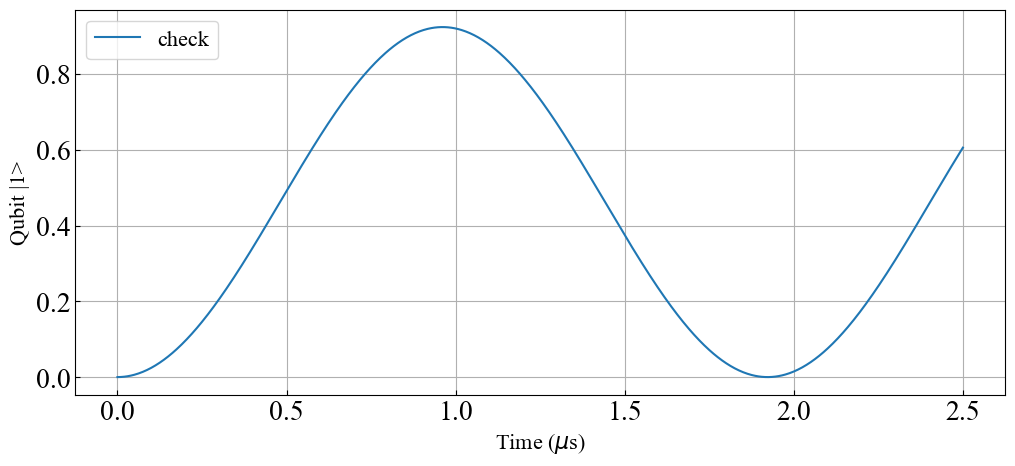

In [277]:
c_photon = tensor(ket("1",device['N_q'])*bra("1",device['N_q']),  qeye(device['N_m']))

result = []
for ii in output.states:
    result.append(expect(c_photon, ii))
print(max(result))

fig, ax = plt.subplots(1, 1, figsize=(12,5))

ax.plot(tlist, result, label='check')
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel('Qubit |1>')
ax.tick_params(labelsize=20)
# plt.axvline(ge_length)
plt.legend(fontsize=16, loc=2)
plt.grid()

# integrable system

In [397]:
def IT_system(tlist, t0, psi0, device):

    # Q, M
    # curoff photon number
    N_m = device['N_m']
    number = 7   # consider 1 center mode 7 spin system


    g_list = device['g_list']



    ## define driving operators
    Ifull = tensor(qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m))
    a_c = tensor(destroy(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m))
    a_m1 = tensor(qeye(N_m), destroy(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m))
    a_m2 = tensor(qeye(N_m), qeye(N_m), destroy(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m))
    a_m3 = tensor(qeye(N_m), qeye(N_m), qeye(N_m), destroy(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m))
    a_m4 = tensor(qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), destroy(N_m), qeye(N_m), qeye(N_m), qeye(N_m))
    a_m5 = tensor(qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), destroy(N_m), qeye(N_m), qeye(N_m))
    a_m6 = tensor(qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), destroy(N_m), qeye(N_m))
    a_m7 = tensor(qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), destroy(N_m))

    z_c = tensor(sigmaz(), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m))/2
    z_m1 = tensor(qeye(N_m), sigmaz(), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m))/2
    z_m2 = tensor(qeye(N_m), qeye(N_m), sigmaz(), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m))/2
    z_m3 = tensor(qeye(N_m), qeye(N_m), qeye(N_m), sigmaz(), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m))/2
    z_m4 = tensor(qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), sigmaz(), qeye(N_m), qeye(N_m), qeye(N_m))/2
    z_m5 = tensor(qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), sigmaz(), qeye(N_m), qeye(N_m))/2
    z_m6 = tensor(qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), sigmaz(), qeye(N_m))/2
    z_m7 = tensor(qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), sigmaz())/2

    zc = a_c.dag()*a_c
    z1 = a_m1.dag()*a_m1
    z2 = a_m2.dag()*a_m2
    z3 = a_m3.dag()*a_m3
    z4 = a_m4.dag()*a_m4
    z5 = a_m5.dag()*a_m5
    z6 = a_m6.dag()*a_m6
    z7 = a_m7.dag()*a_m7


    # destroy(2):  S+;  destroy(2).dag():  S-; z_i: Sz

    Q1 = -2*z_c*z_m1+1/2*(a_m1.dag()*a_m1+a_m1*a_m1.dag())
    Q1 += g_list[0]*g_list[1]/(g_list[0]**2-g_list[1]**2)*(a_m1.dag()*a_m2+a_m1*a_m2.dag())+2*g_list[1]**2/(g_list[0]**2-g_list[1]**2)*z_m1*z_m2
    Q1 += g_list[0]*g_list[2]/(g_list[0]**2-g_list[2]**2)*(a_m1.dag()*a_m3+a_m1*a_m3.dag())+2*g_list[2]**2/(g_list[0]**2-g_list[2]**2)*z_m1*z_m3
    Q1 += g_list[0]*g_list[3]/(g_list[0]**2-g_list[3]**2)*(a_m1.dag()*a_m4+a_m1*a_m4.dag())+2*g_list[3]**2/(g_list[0]**2-g_list[3]**2)*z_m1*z_m4
    Q1 += g_list[0]*g_list[4]/(g_list[0]**2-g_list[4]**2)*(a_m1.dag()*a_m5+a_m1*a_m5.dag())+2*g_list[4]**2/(g_list[0]**2-g_list[4]**2)*z_m1*z_m5
    Q1 += g_list[0]*g_list[5]/(g_list[0]**2-g_list[5]**2)*(a_m1.dag()*a_m6+a_m1*a_m6.dag())+2*g_list[5]**2/(g_list[0]**2-g_list[5]**2)*z_m1*z_m6
    Q1 += g_list[0]*g_list[6]/(g_list[0]**2-g_list[6]**2)*(a_m1.dag()*a_m7+a_m1*a_m7.dag())+2*g_list[6]**2/(g_list[0]**2-g_list[6]**2)*z_m1*z_m7

    Q2 = -2*z_c*z_m2+1/2*(a_m2.dag()*a_m2+a_m2*a_m2.dag())
    Q2 += g_list[1]*g_list[0]/(g_list[1]**2-g_list[0]**2)*(a_m2.dag()*a_m1+a_m2*a_m1.dag())+2*g_list[0]**2/(g_list[1]**2-g_list[0]**2)*z_m2*z_m1
    Q2 += g_list[1]*g_list[2]/(g_list[1]**2-g_list[2]**2)*(a_m2.dag()*a_m3+a_m2*a_m3.dag())+2*g_list[2]**2/(g_list[1]**2-g_list[2]**2)*z_m2*z_m3
    Q2 += g_list[1]*g_list[3]/(g_list[1]**2-g_list[3]**2)*(a_m2.dag()*a_m4+a_m2*a_m4.dag())+2*g_list[3]**2/(g_list[1]**2-g_list[3]**2)*z_m2*z_m4
    Q2 += g_list[1]*g_list[4]/(g_list[1]**2-g_list[4]**2)*(a_m2.dag()*a_m5+a_m2*a_m5.dag())+2*g_list[4]**2/(g_list[1]**2-g_list[4]**2)*z_m2*z_m5
    Q2 += g_list[1]*g_list[5]/(g_list[1]**2-g_list[5]**2)*(a_m2.dag()*a_m6+a_m2*a_m6.dag())+2*g_list[5]**2/(g_list[1]**2-g_list[5]**2)*z_m2*z_m6
    Q2 += g_list[1]*g_list[6]/(g_list[1]**2-g_list[6]**2)*(a_m2.dag()*a_m7+a_m2*a_m7.dag())+2*g_list[6]**2/(g_list[1]**2-g_list[6]**2)*z_m2*z_m7

    Q3 = -2*z_c*z_m3+1/2*(a_m3.dag()*a_m3+a_m3*a_m3.dag())
    Q3 += g_list[2]*g_list[0]/(g_list[2]**2-g_list[0]**2)*(a_m3.dag()*a_m1+a_m3*a_m1.dag())+2*g_list[0]**2/(g_list[2]**2-g_list[0]**2)*z_m3*z_m1
    Q3 += g_list[2]*g_list[1]/(g_list[2]**2-g_list[1]**2)*(a_m3.dag()*a_m2+a_m3*a_m2.dag())+2*g_list[1]**2/(g_list[2]**2-g_list[1]**2)*z_m3*z_m2
    Q3 += g_list[2]*g_list[3]/(g_list[2]**2-g_list[3]**2)*(a_m3.dag()*a_m4+a_m3*a_m4.dag())+2*g_list[3]**2/(g_list[2]**2-g_list[3]**2)*z_m3*z_m4
    Q3 += g_list[2]*g_list[4]/(g_list[2]**2-g_list[4]**2)*(a_m3.dag()*a_m5+a_m3*a_m5.dag())+2*g_list[4]**2/(g_list[2]**2-g_list[4]**2)*z_m3*z_m5
    Q3 += g_list[2]*g_list[5]/(g_list[2]**2-g_list[5]**2)*(a_m3.dag()*a_m6+a_m3*a_m6.dag())+2*g_list[5]**2/(g_list[2]**2-g_list[5]**2)*z_m3*z_m6
    Q3 += g_list[2]*g_list[6]/(g_list[2]**2-g_list[6]**2)*(a_m3.dag()*a_m7+a_m3*a_m7.dag())+2*g_list[6]**2/(g_list[2]**2-g_list[6]**2)*z_m3*z_m7

    Q4 = -2*z_c*z_m4+1/2*(a_m4.dag()*a_m4+a_m4*a_m4.dag())
    Q4 += g_list[3]*g_list[1]/(g_list[3]**2-g_list[1]**2)*(a_m4.dag()*a_m2+a_m4*a_m2.dag())+2*g_list[1]**2/(g_list[3]**2-g_list[1]**2)*z_m4*z_m2
    Q4 += g_list[3]*g_list[2]/(g_list[3]**2-g_list[2]**2)*(a_m4.dag()*a_m3+a_m4*a_m3.dag())+2*g_list[2]**2/(g_list[3]**2-g_list[2]**2)*z_m4*z_m3
    Q4 += g_list[3]*g_list[0]/(g_list[3]**2-g_list[0]**2)*(a_m4.dag()*a_m1+a_m4*a_m1.dag())+2*g_list[0]**2/(g_list[3]**2-g_list[0]**2)*z_m4*z_m1
    Q4 += g_list[3]*g_list[4]/(g_list[3]**2-g_list[4]**2)*(a_m4.dag()*a_m5+a_m4*a_m5.dag())+2*g_list[4]**2/(g_list[3]**2-g_list[4]**2)*z_m4*z_m5
    Q4 += g_list[3]*g_list[5]/(g_list[3]**2-g_list[5]**2)*(a_m4.dag()*a_m6+a_m4*a_m6.dag())+2*g_list[5]**2/(g_list[3]**2-g_list[5]**2)*z_m4*z_m6
    Q4 += g_list[3]*g_list[6]/(g_list[3]**2-g_list[6]**2)*(a_m4.dag()*a_m7+a_m4*a_m7.dag())+2*g_list[6]**2/(g_list[3]**2-g_list[6]**2)*z_m4*z_m7

    Q5 = -2*z_c*z_m5+1/2*(a_m5.dag()*a_m5+a_m5*a_m5.dag())
    Q5 += g_list[4]*g_list[1]/(g_list[4]**2-g_list[1]**2)*(a_m5.dag()*a_m2+a_m5*a_m2.dag())+2*g_list[1]**2/(g_list[4]**2-g_list[1]**2)*z_m5*z_m2
    Q5 += g_list[4]*g_list[2]/(g_list[4]**2-g_list[2]**2)*(a_m5.dag()*a_m3+a_m5*a_m3.dag())+2*g_list[2]**2/(g_list[4]**2-g_list[2]**2)*z_m5*z_m3
    Q5 += g_list[4]*g_list[3]/(g_list[4]**2-g_list[3]**2)*(a_m5.dag()*a_m4+a_m5*a_m4.dag())+2*g_list[3]**2/(g_list[4]**2-g_list[3]**2)*z_m5*z_m4
    Q5 += g_list[4]*g_list[0]/(g_list[4]**2-g_list[0]**2)*(a_m5.dag()*a_m1+a_m5*a_m1.dag())+2*g_list[0]**2/(g_list[4]**2-g_list[0]**2)*z_m5*z_m1
    Q5 += g_list[4]*g_list[5]/(g_list[4]**2-g_list[5]**2)*(a_m5.dag()*a_m6+a_m5*a_m6.dag())+2*g_list[5]**2/(g_list[4]**2-g_list[5]**2)*z_m5*z_m6
    Q5 += g_list[4]*g_list[6]/(g_list[4]**2-g_list[6]**2)*(a_m5.dag()*a_m7+a_m5*a_m7.dag())+2*g_list[6]**2/(g_list[4]**2-g_list[6]**2)*z_m5*z_m7

    Q6 = -2*z_c*z_m6+1/2*(a_m6.dag()*a_m6+a_m6*a_m6.dag())
    Q6 += g_list[5]*g_list[1]/(g_list[5]**2-g_list[1]**2)*(a_m6.dag()*a_m2+a_m6*a_m2.dag())+2*g_list[1]**2/(g_list[5]**2-g_list[1]**2)*z_m6*z_m2
    Q6 += g_list[5]*g_list[2]/(g_list[5]**2-g_list[2]**2)*(a_m6.dag()*a_m3+a_m6*a_m3.dag())+2*g_list[2]**2/(g_list[5]**2-g_list[2]**2)*z_m6*z_m3
    Q6 += g_list[5]*g_list[3]/(g_list[5]**2-g_list[3]**2)*(a_m6.dag()*a_m4+a_m6*a_m4.dag())+2*g_list[3]**2/(g_list[5]**2-g_list[3]**2)*z_m6*z_m4
    Q6 += g_list[5]*g_list[4]/(g_list[5]**2-g_list[4]**2)*(a_m6.dag()*a_m5+a_m6*a_m5.dag())+2*g_list[4]**2/(g_list[5]**2-g_list[4]**2)*z_m6*z_m5
    Q6 += g_list[5]*g_list[0]/(g_list[5]**2-g_list[0]**2)*(a_m6.dag()*a_m1+a_m6*a_m1.dag())+2*g_list[0]**2/(g_list[5]**2-g_list[0]**2)*z_m6*z_m1
    Q6 += g_list[5]*g_list[6]/(g_list[5]**2-g_list[6]**2)*(a_m6.dag()*a_m7+a_m6*a_m7.dag())+2*g_list[6]**2/(g_list[5]**2-g_list[6]**2)*z_m6*z_m7

    Q7 = -2*z_c*z_m7+1/2*(a_m7.dag()*a_m7+a_m7*a_m7.dag())
    Q7 += g_list[6]*g_list[1]/(g_list[6]**2-g_list[1]**2)*(a_m7.dag()*a_m2+a_m7*a_m2.dag())+2*g_list[1]**2/(g_list[6]**2-g_list[1]**2)*z_m7*z_m2
    Q7 += g_list[6]*g_list[2]/(g_list[6]**2-g_list[2]**2)*(a_m7.dag()*a_m3+a_m7*a_m3.dag())+2*g_list[2]**2/(g_list[6]**2-g_list[2]**2)*z_m7*z_m3
    Q7 += g_list[6]*g_list[3]/(g_list[6]**2-g_list[3]**2)*(a_m7.dag()*a_m4+a_m7*a_m4.dag())+2*g_list[3]**2/(g_list[6]**2-g_list[3]**2)*z_m7*z_m4
    Q7 += g_list[6]*g_list[4]/(g_list[6]**2-g_list[4]**2)*(a_m7.dag()*a_m5+a_m7*a_m5.dag())+2*g_list[4]**2/(g_list[6]**2-g_list[4]**2)*z_m7*z_m5
    Q7 += g_list[6]*g_list[5]/(g_list[6]**2-g_list[5]**2)*(a_m7.dag()*a_m6+a_m7*a_m6.dag())+2*g_list[5]**2/(g_list[6]**2-g_list[5]**2)*z_m7*z_m6
    Q7 += g_list[6]*g_list[0]/(g_list[6]**2-g_list[0]**2)*(a_m7.dag()*a_m1+a_m7*a_m1.dag())+2*g_list[0]**2/(g_list[6]**2-g_list[0]**2)*z_m7*z_m1

    # P0 = Ifull-zc*zc

    # Q1 = (a_m1.dag()*a_m1+a_m1*a_m1.dag())/2





    # system static hamiltonan (ZZ part)
    H_0 = g_list[0]*(a_c*a_m1.dag()+a_c.dag()*a_m1)
    H_0 += g_list[1]*(a_c*a_m2.dag()+a_c.dag()*a_m2)
    H_0 += g_list[2]*(a_c*a_m3.dag()+a_c.dag()*a_m3)
    H_0 += g_list[3]*(a_c*a_m4.dag()+a_c.dag()*a_m4)
    H_0 += g_list[4]*(a_c*a_m5.dag()+a_c.dag()*a_m5)
    H_0 += g_list[5]*(a_c*a_m6.dag()+a_c.dag()*a_m6)
    H_0 += g_list[6]*(a_c*a_m7.dag()+a_c.dag()*a_m7)
    QQ = H_0*H_0



    H_t = [H_0]


    c_ops = []



    # print('Running mesolve...')
    args = {}
    result = mesolve(H_t, psi0, tlist+t0, c_ops, [zc, z1,z2,z3,z4,z5,z6,z7, QQ, Q1, Q2, Q3, Q4, Q5, Q6, Q7], args, options=options)

    tend = tlist[-1]+t0
    psi1 = result.states[-1]


    return psi1, tend, result

In [398]:
device = {}


device['N_m'] = 2
device['g_list'] = np.array([0.3,0.2,0.4,0.5,0.25,0.35,0.32]) * np.pi * 2
psi0 = tensor(ket("1", device['N_m']),ket("0", device['N_m']),ket("1", device['N_m']),ket("0", device['N_m']),ket("0", device['N_m']),ket("0", device['N_m']),ket("1", device['N_m']),ket("0", device['N_m']))


psi0 = psi0.unit()
tlist = np.linspace(0, 5, 1001)
psi1, tend, output = IT_system(tlist, 0, psi0, device)

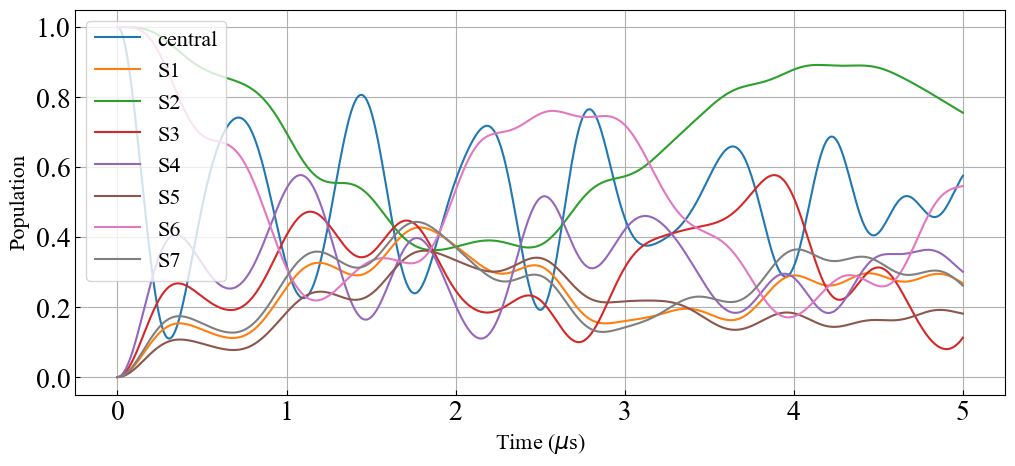

In [399]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))

plt.plot(tlist, output.expect[0], label='central')
plt.plot(tlist, output.expect[1], label='S1')
plt.plot(tlist, output.expect[2], label='S2')
plt.plot(tlist, output.expect[3], label='S3')
plt.plot(tlist, output.expect[4], label='S4')
plt.plot(tlist, output.expect[5], label='S5')
plt.plot(tlist, output.expect[6], label='S6')
plt.plot(tlist, output.expect[7], label='S7')

ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel('Population')
ax.tick_params(labelsize=20)
plt.grid()
plt.legend()

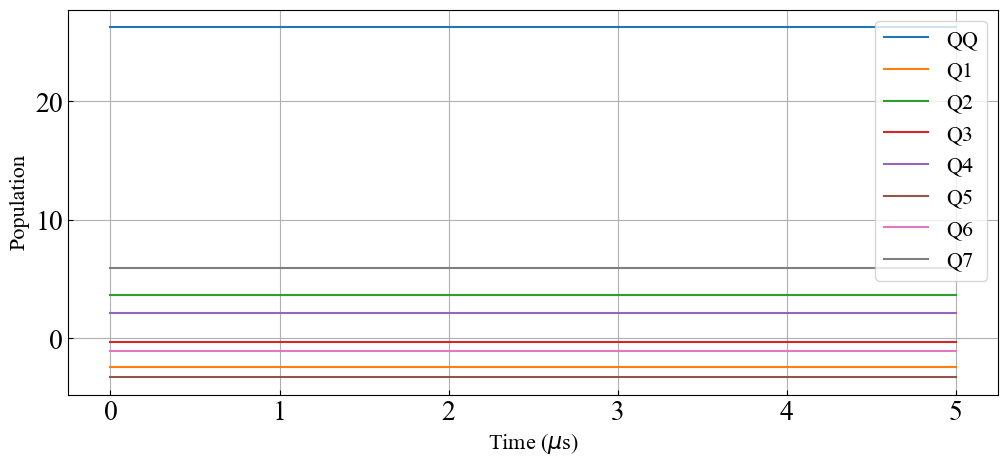

In [400]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))

# plt.plot(tlist, output.expect[0], label='central')
plt.plot(tlist, output.expect[-8], label='QQ')
plt.plot(tlist, output.expect[-7], label='Q1')
plt.plot(tlist, output.expect[-6], label='Q2')
plt.plot(tlist, output.expect[-5], label='Q3')
plt.plot(tlist, output.expect[-4], label='Q4')
plt.plot(tlist, output.expect[-3], label='Q5')
plt.plot(tlist, output.expect[-2], label='Q6')
plt.plot(tlist, output.expect[-1], label='Q7')

ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel('Population')
ax.tick_params(labelsize=20)
plt.grid()
plt.legend()

## what if doing a pulsed version?

In [401]:
def IT_system1(tlist, t0, psi0, device):

    # Q, M
    # curoff photon number
    N_m = device['N_m']
    number = 7   # consider 1 center mode 7 spin system


    g_list = device['g_list_raw']/7   # averaged version
    g_list1 = device['g_list']  # actual pulsing version



    ## define driving operators
    Ifull = tensor(qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m))
    a_c = tensor(destroy(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m))
    a_m1 = tensor(qeye(N_m), destroy(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m))
    a_m2 = tensor(qeye(N_m), qeye(N_m), destroy(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m))
    a_m3 = tensor(qeye(N_m), qeye(N_m), qeye(N_m), destroy(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m))
    a_m4 = tensor(qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), destroy(N_m), qeye(N_m), qeye(N_m), qeye(N_m))
    a_m5 = tensor(qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), destroy(N_m), qeye(N_m), qeye(N_m))
    a_m6 = tensor(qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), destroy(N_m), qeye(N_m))
    a_m7 = tensor(qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), destroy(N_m))

    z_c = tensor(sigmaz(), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m))/2
    z_m1 = tensor(qeye(N_m), sigmaz(), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m))/2
    z_m2 = tensor(qeye(N_m), qeye(N_m), sigmaz(), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m))/2
    z_m3 = tensor(qeye(N_m), qeye(N_m), qeye(N_m), sigmaz(), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m))/2
    z_m4 = tensor(qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), sigmaz(), qeye(N_m), qeye(N_m), qeye(N_m))/2
    z_m5 = tensor(qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), sigmaz(), qeye(N_m), qeye(N_m))/2
    z_m6 = tensor(qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), sigmaz(), qeye(N_m))/2
    z_m7 = tensor(qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), qeye(N_m), sigmaz())/2

    zc = a_c.dag()*a_c
    z1 = a_m1.dag()*a_m1
    z2 = a_m2.dag()*a_m2
    z3 = a_m3.dag()*a_m3
    z4 = a_m4.dag()*a_m4
    z5 = a_m5.dag()*a_m5
    z6 = a_m6.dag()*a_m6
    z7 = a_m7.dag()*a_m7


    # destroy(2):  S+;  destroy(2).dag():  S-; z_i: Sz

    Q1 = -2*z_c*z_m1+1/2*(a_m1.dag()*a_m1+a_m1*a_m1.dag())
    Q1 += g_list[0]*g_list[1]/(g_list[0]**2-g_list[1]**2)*(a_m1.dag()*a_m2+a_m1*a_m2.dag())+2*g_list[1]**2/(g_list[0]**2-g_list[1]**2)*z_m1*z_m2
    Q1 += g_list[0]*g_list[2]/(g_list[0]**2-g_list[2]**2)*(a_m1.dag()*a_m3+a_m1*a_m3.dag())+2*g_list[2]**2/(g_list[0]**2-g_list[2]**2)*z_m1*z_m3
    Q1 += g_list[0]*g_list[3]/(g_list[0]**2-g_list[3]**2)*(a_m1.dag()*a_m4+a_m1*a_m4.dag())+2*g_list[3]**2/(g_list[0]**2-g_list[3]**2)*z_m1*z_m4
    Q1 += g_list[0]*g_list[4]/(g_list[0]**2-g_list[4]**2)*(a_m1.dag()*a_m5+a_m1*a_m5.dag())+2*g_list[4]**2/(g_list[0]**2-g_list[4]**2)*z_m1*z_m5
    Q1 += g_list[0]*g_list[5]/(g_list[0]**2-g_list[5]**2)*(a_m1.dag()*a_m6+a_m1*a_m6.dag())+2*g_list[5]**2/(g_list[0]**2-g_list[5]**2)*z_m1*z_m6
    Q1 += g_list[0]*g_list[6]/(g_list[0]**2-g_list[6]**2)*(a_m1.dag()*a_m7+a_m1*a_m7.dag())+2*g_list[6]**2/(g_list[0]**2-g_list[6]**2)*z_m1*z_m7

    Q2 = -2*z_c*z_m2+1/2*(a_m2.dag()*a_m2+a_m2*a_m2.dag())
    Q2 += g_list[1]*g_list[0]/(g_list[1]**2-g_list[0]**2)*(a_m2.dag()*a_m1+a_m2*a_m1.dag())+2*g_list[0]**2/(g_list[1]**2-g_list[0]**2)*z_m2*z_m1
    Q2 += g_list[1]*g_list[2]/(g_list[1]**2-g_list[2]**2)*(a_m2.dag()*a_m3+a_m2*a_m3.dag())+2*g_list[2]**2/(g_list[1]**2-g_list[2]**2)*z_m2*z_m3
    Q2 += g_list[1]*g_list[3]/(g_list[1]**2-g_list[3]**2)*(a_m2.dag()*a_m4+a_m2*a_m4.dag())+2*g_list[3]**2/(g_list[1]**2-g_list[3]**2)*z_m2*z_m4
    Q2 += g_list[1]*g_list[4]/(g_list[1]**2-g_list[4]**2)*(a_m2.dag()*a_m5+a_m2*a_m5.dag())+2*g_list[4]**2/(g_list[1]**2-g_list[4]**2)*z_m2*z_m5
    Q2 += g_list[1]*g_list[5]/(g_list[1]**2-g_list[5]**2)*(a_m2.dag()*a_m6+a_m2*a_m6.dag())+2*g_list[5]**2/(g_list[1]**2-g_list[5]**2)*z_m2*z_m6
    Q2 += g_list[1]*g_list[6]/(g_list[1]**2-g_list[6]**2)*(a_m2.dag()*a_m7+a_m2*a_m7.dag())+2*g_list[6]**2/(g_list[1]**2-g_list[6]**2)*z_m2*z_m7

    Q3 = -2*z_c*z_m3+1/2*(a_m3.dag()*a_m3+a_m3*a_m3.dag())
    Q3 += g_list[2]*g_list[0]/(g_list[2]**2-g_list[0]**2)*(a_m3.dag()*a_m1+a_m3*a_m1.dag())+2*g_list[0]**2/(g_list[2]**2-g_list[0]**2)*z_m3*z_m1
    Q3 += g_list[2]*g_list[1]/(g_list[2]**2-g_list[1]**2)*(a_m3.dag()*a_m2+a_m3*a_m2.dag())+2*g_list[1]**2/(g_list[2]**2-g_list[1]**2)*z_m3*z_m2
    Q3 += g_list[2]*g_list[3]/(g_list[2]**2-g_list[3]**2)*(a_m3.dag()*a_m4+a_m3*a_m4.dag())+2*g_list[3]**2/(g_list[2]**2-g_list[3]**2)*z_m3*z_m4
    Q3 += g_list[2]*g_list[4]/(g_list[2]**2-g_list[4]**2)*(a_m3.dag()*a_m5+a_m3*a_m5.dag())+2*g_list[4]**2/(g_list[2]**2-g_list[4]**2)*z_m3*z_m5
    Q3 += g_list[2]*g_list[5]/(g_list[2]**2-g_list[5]**2)*(a_m3.dag()*a_m6+a_m3*a_m6.dag())+2*g_list[5]**2/(g_list[2]**2-g_list[5]**2)*z_m3*z_m6
    Q3 += g_list[2]*g_list[6]/(g_list[2]**2-g_list[6]**2)*(a_m3.dag()*a_m7+a_m3*a_m7.dag())+2*g_list[6]**2/(g_list[2]**2-g_list[6]**2)*z_m3*z_m7

    Q4 = -2*z_c*z_m4+1/2*(a_m4.dag()*a_m4+a_m4*a_m4.dag())
    Q4 += g_list[3]*g_list[1]/(g_list[3]**2-g_list[1]**2)*(a_m4.dag()*a_m2+a_m4*a_m2.dag())+2*g_list[1]**2/(g_list[3]**2-g_list[1]**2)*z_m4*z_m2
    Q4 += g_list[3]*g_list[2]/(g_list[3]**2-g_list[2]**2)*(a_m4.dag()*a_m3+a_m4*a_m3.dag())+2*g_list[2]**2/(g_list[3]**2-g_list[2]**2)*z_m4*z_m3
    Q4 += g_list[3]*g_list[0]/(g_list[3]**2-g_list[0]**2)*(a_m4.dag()*a_m1+a_m4*a_m1.dag())+2*g_list[0]**2/(g_list[3]**2-g_list[0]**2)*z_m4*z_m1
    Q4 += g_list[3]*g_list[4]/(g_list[3]**2-g_list[4]**2)*(a_m4.dag()*a_m5+a_m4*a_m5.dag())+2*g_list[4]**2/(g_list[3]**2-g_list[4]**2)*z_m4*z_m5
    Q4 += g_list[3]*g_list[5]/(g_list[3]**2-g_list[5]**2)*(a_m4.dag()*a_m6+a_m4*a_m6.dag())+2*g_list[5]**2/(g_list[3]**2-g_list[5]**2)*z_m4*z_m6
    Q4 += g_list[3]*g_list[6]/(g_list[3]**2-g_list[6]**2)*(a_m4.dag()*a_m7+a_m4*a_m7.dag())+2*g_list[6]**2/(g_list[3]**2-g_list[6]**2)*z_m4*z_m7

    Q5 = -2*z_c*z_m5+1/2*(a_m5.dag()*a_m5+a_m5*a_m5.dag())
    Q5 += g_list[4]*g_list[1]/(g_list[4]**2-g_list[1]**2)*(a_m5.dag()*a_m2+a_m5*a_m2.dag())+2*g_list[1]**2/(g_list[4]**2-g_list[1]**2)*z_m5*z_m2
    Q5 += g_list[4]*g_list[2]/(g_list[4]**2-g_list[2]**2)*(a_m5.dag()*a_m3+a_m5*a_m3.dag())+2*g_list[2]**2/(g_list[4]**2-g_list[2]**2)*z_m5*z_m3
    Q5 += g_list[4]*g_list[3]/(g_list[4]**2-g_list[3]**2)*(a_m5.dag()*a_m4+a_m5*a_m4.dag())+2*g_list[3]**2/(g_list[4]**2-g_list[3]**2)*z_m5*z_m4
    Q5 += g_list[4]*g_list[0]/(g_list[4]**2-g_list[0]**2)*(a_m5.dag()*a_m1+a_m5*a_m1.dag())+2*g_list[0]**2/(g_list[4]**2-g_list[0]**2)*z_m5*z_m1
    Q5 += g_list[4]*g_list[5]/(g_list[4]**2-g_list[5]**2)*(a_m5.dag()*a_m6+a_m5*a_m6.dag())+2*g_list[5]**2/(g_list[4]**2-g_list[5]**2)*z_m5*z_m6
    Q5 += g_list[4]*g_list[6]/(g_list[4]**2-g_list[6]**2)*(a_m5.dag()*a_m7+a_m5*a_m7.dag())+2*g_list[6]**2/(g_list[4]**2-g_list[6]**2)*z_m5*z_m7

    Q6 = -2*z_c*z_m6+1/2*(a_m6.dag()*a_m6+a_m6*a_m6.dag())
    Q6 += g_list[5]*g_list[1]/(g_list[5]**2-g_list[1]**2)*(a_m6.dag()*a_m2+a_m6*a_m2.dag())+2*g_list[1]**2/(g_list[5]**2-g_list[1]**2)*z_m6*z_m2
    Q6 += g_list[5]*g_list[2]/(g_list[5]**2-g_list[2]**2)*(a_m6.dag()*a_m3+a_m6*a_m3.dag())+2*g_list[2]**2/(g_list[5]**2-g_list[2]**2)*z_m6*z_m3
    Q6 += g_list[5]*g_list[3]/(g_list[5]**2-g_list[3]**2)*(a_m6.dag()*a_m4+a_m6*a_m4.dag())+2*g_list[3]**2/(g_list[5]**2-g_list[3]**2)*z_m6*z_m4
    Q6 += g_list[5]*g_list[4]/(g_list[5]**2-g_list[4]**2)*(a_m6.dag()*a_m5+a_m6*a_m5.dag())+2*g_list[4]**2/(g_list[5]**2-g_list[4]**2)*z_m6*z_m5
    Q6 += g_list[5]*g_list[0]/(g_list[5]**2-g_list[0]**2)*(a_m6.dag()*a_m1+a_m6*a_m1.dag())+2*g_list[0]**2/(g_list[5]**2-g_list[0]**2)*z_m6*z_m1
    Q6 += g_list[5]*g_list[6]/(g_list[5]**2-g_list[6]**2)*(a_m6.dag()*a_m7+a_m6*a_m7.dag())+2*g_list[6]**2/(g_list[5]**2-g_list[6]**2)*z_m6*z_m7

    Q7 = -2*z_c*z_m7+1/2*(a_m7.dag()*a_m7+a_m7*a_m7.dag())
    Q7 += g_list[6]*g_list[1]/(g_list[6]**2-g_list[1]**2)*(a_m7.dag()*a_m2+a_m7*a_m2.dag())+2*g_list[1]**2/(g_list[6]**2-g_list[1]**2)*z_m7*z_m2
    Q7 += g_list[6]*g_list[2]/(g_list[6]**2-g_list[2]**2)*(a_m7.dag()*a_m3+a_m7*a_m3.dag())+2*g_list[2]**2/(g_list[6]**2-g_list[2]**2)*z_m7*z_m3
    Q7 += g_list[6]*g_list[3]/(g_list[6]**2-g_list[3]**2)*(a_m7.dag()*a_m4+a_m7*a_m4.dag())+2*g_list[3]**2/(g_list[6]**2-g_list[3]**2)*z_m7*z_m4
    Q7 += g_list[6]*g_list[4]/(g_list[6]**2-g_list[4]**2)*(a_m7.dag()*a_m5+a_m7*a_m5.dag())+2*g_list[4]**2/(g_list[6]**2-g_list[4]**2)*z_m7*z_m5
    Q7 += g_list[6]*g_list[5]/(g_list[6]**2-g_list[5]**2)*(a_m7.dag()*a_m6+a_m7*a_m6.dag())+2*g_list[5]**2/(g_list[6]**2-g_list[5]**2)*z_m7*z_m6
    Q7 += g_list[6]*g_list[0]/(g_list[6]**2-g_list[0]**2)*(a_m7.dag()*a_m1+a_m7*a_m1.dag())+2*g_list[0]**2/(g_list[6]**2-g_list[0]**2)*z_m7*z_m1

    # P0 = Ifull-zc*zc

    # Q1 = (a_m1.dag()*a_m1+a_m1*a_m1.dag())/2





    # system static hamiltonan (ZZ part)
    H_0 = g_list1[0]*(a_c*a_m1.dag()+a_c.dag()*a_m1)
    H_0 += g_list1[1]*(a_c*a_m2.dag()+a_c.dag()*a_m2)
    H_0 += g_list1[2]*(a_c*a_m3.dag()+a_c.dag()*a_m3)
    H_0 += g_list1[3]*(a_c*a_m4.dag()+a_c.dag()*a_m4)
    H_0 += g_list1[4]*(a_c*a_m5.dag()+a_c.dag()*a_m5)
    H_0 += g_list1[5]*(a_c*a_m6.dag()+a_c.dag()*a_m6)
    H_0 += g_list1[6]*(a_c*a_m7.dag()+a_c.dag()*a_m7)
    QQ = g_list[0]**2*Q1+g_list[1]**2*Q2+g_list[2]**2*Q3+g_list[3]**2*Q4+g_list[4]**2*Q5+g_list[5]**2*Q6+g_list[6]**2*Q7



    H_t = [H_0]


    c_ops = []



    # print('Running mesolve...')
    args = {}
    result = mesolve(H_t, psi0, tlist+t0, c_ops, [zc, z1,z2,z3,z4,z5,z6,z7, QQ, Q1, Q2, Q3, Q4, Q5, Q6, Q7], args, options=options)

    tend = tlist[-1]+t0
    psi1 = result.states[-1]


    return psi1, tend, result

In [402]:
t_list_list = []
sec_length = 0.01
sec_no = 1000

t_now = 0

for i in range(sec_no):
    t_list_list.append(np.linspace(t_now, t_now+sec_length, 501))
    t_now += sec_length

device = {}

device['N_m'] = 2
device['g_list_raw'] = np.array([0.3,0.2,0.4,0.5,0.25,0.35,0.32]) * np.pi * 2
# psi0 = tensor(ket("1", device['N_m']),ket("0", device['N_m']),ket("0", device['N_m']),ket("0", device['N_m']),ket("0", device['N_m']),ket("0", device['N_m']),ket("0", device['N_m']),ket("0", device['N_m']))
psi0 = tensor(ket("1", device['N_m']),ket("0", device['N_m']),ket("1", device['N_m']),ket("0", device['N_m']),ket("0", device['N_m']),ket("0", device['N_m']),ket("1", device['N_m']),ket("0", device['N_m']))


psi0 = psi0.unit()
psi_now = psi0

QQ = []
Q7 = []
Q1 = []
Q2 = []
Q3 = []
Q4 = []
Q5 = []
Q6 = []
cen = []
S1 = []
S2 = []
S3 = []
S4 = []
S5 = []
S6 = []
S7 = []


for i in range(len(t_list_list)):
    if i%20 == 1: print('calculating: ', i)

    aa = np.zeros(7)
    aa[i%7] = 1

    device['g_list'] = np.array([0.3,0.2,0.4,0.5,0.25,0.35,0.32]) * np.pi * 2

    device['g_list'] = device['g_list']*aa

    psi1, tend, output = IT_system1(t_list_list[i], 0, psi_now, device)
    # collect data
    QQ.append(output.expect[-8])
    Q1.append(output.expect[-7])
    Q2.append(output.expect[-6])
    Q3.append(output.expect[-5])
    Q4.append(output.expect[-4])
    Q5.append(output.expect[-3])
    Q6.append(output.expect[-2])
    Q7.append(output.expect[-1])

    cen.append(output.expect[0])
    S1.append(output.expect[1])
    S2.append(output.expect[2])
    S3.append(output.expect[3])
    S4.append(output.expect[4])
    S5.append(output.expect[5])
    S6.append(output.expect[6])
    S7.append(output.expect[7])

    psi_now = psi1

calculating:  1
calculating:  21
calculating:  41
calculating:  61
calculating:  81
calculating:  101
calculating:  121
calculating:  141
calculating:  161
calculating:  181
calculating:  201
calculating:  221
calculating:  241
calculating:  261
calculating:  281
calculating:  301
calculating:  321
calculating:  341
calculating:  361
calculating:  381
calculating:  401
calculating:  421
calculating:  441
calculating:  461
calculating:  481
calculating:  501
calculating:  521
calculating:  541
calculating:  561
calculating:  581
calculating:  601
calculating:  621
calculating:  641
calculating:  661
calculating:  681
calculating:  701
calculating:  721
calculating:  741
calculating:  761
calculating:  781
calculating:  801
calculating:  821
calculating:  841
calculating:  861
calculating:  881
calculating:  901
calculating:  921
calculating:  941
calculating:  961
calculating:  981


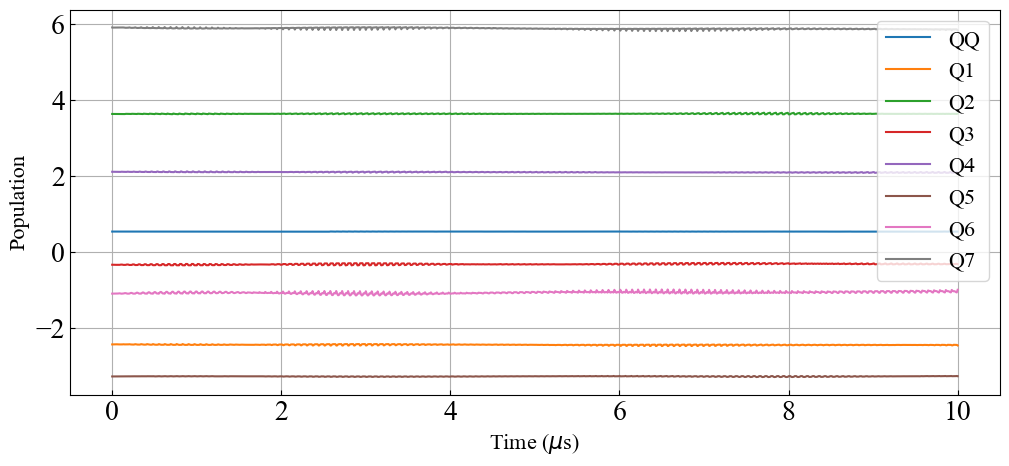

In [403]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))

# plt.plot(tlist, output.expect[0], label='central')
plt.plot(np.concatenate(t_list_list), np.concatenate(QQ), label='QQ')
plt.plot(np.concatenate(t_list_list), np.concatenate(Q1), label='Q1')
plt.plot(np.concatenate(t_list_list), np.concatenate(Q2), label='Q2')
plt.plot(np.concatenate(t_list_list), np.concatenate(Q3), label='Q3')
plt.plot(np.concatenate(t_list_list), np.concatenate(Q4), label='Q4')
plt.plot(np.concatenate(t_list_list), np.concatenate(Q5), label='Q5')
plt.plot(np.concatenate(t_list_list), np.concatenate(Q6), label='Q6')
plt.plot(np.concatenate(t_list_list), np.concatenate(Q7), label='Q7')

ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel('Population')
ax.tick_params(labelsize=20)
plt.grid()
plt.legend()

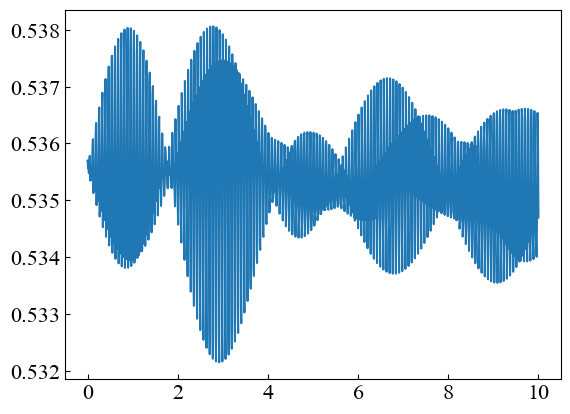

In [404]:
plt.plot(np.concatenate(t_list_list), np.concatenate(QQ), label='QQ')

In [394]:
device

{'N_m': 2,
 'g_list_raw': array([1.88495559, 1.25663706, 2.51327412, 3.14159265, 1.57079633,
        2.19911486, 2.0106193 ]),
 'g_list': array([0.        , 0.        , 0.        , 0.        , 0.        ,
        2.19911486, 0.        ])}

## If using a slow switching

In [406]:
t_list_list = []
sec_length = 0.1
sec_no = 500

t_now = 0

for i in range(sec_no):
    t_list_list.append(np.linspace(t_now, t_now+sec_length, 501))
    t_now += sec_length

device = {}

device['N_m'] = 2
device['g_list_raw'] = np.array([0.3,0.2,0.4,0.5,0.25,0.35,0.32]) * np.pi * 2
# psi0 = tensor(ket("1", device['N_m']),ket("0", device['N_m']),ket("0", device['N_m']),ket("0", device['N_m']),ket("0", device['N_m']),ket("0", device['N_m']),ket("0", device['N_m']),ket("0", device['N_m']))
psi0 = tensor(ket("1", device['N_m']),ket("0", device['N_m']),ket("1", device['N_m']),ket("0", device['N_m']),ket("0", device['N_m']),ket("0", device['N_m']),ket("1", device['N_m']),ket("0", device['N_m']))


psi0 = psi0.unit()
psi_now = psi0

QQ = []
Q7 = []
Q1 = []
Q2 = []
Q3 = []
Q4 = []
Q5 = []
Q6 = []
cen = []
S1 = []
S2 = []
S3 = []
S4 = []
S5 = []
S6 = []
S7 = []


for i in range(len(t_list_list)):
    if i%20 == 1: print('calculating: ', i)

    aa = np.zeros(7)
    aa[i%7] = 1

    device['g_list'] = np.array([0.3,0.2,0.4,0.5,0.25,0.35,0.32]) * np.pi * 2

    device['g_list'] = device['g_list']*aa

    psi1, tend, output = IT_system1(t_list_list[i], 0, psi_now, device)
    # collect data
    QQ.append(output.expect[-8])
    Q1.append(output.expect[-7])
    Q2.append(output.expect[-6])
    Q3.append(output.expect[-5])
    Q4.append(output.expect[-4])
    Q5.append(output.expect[-3])
    Q6.append(output.expect[-2])
    Q7.append(output.expect[-1])

    cen.append(output.expect[0])
    S1.append(output.expect[1])
    S2.append(output.expect[2])
    S3.append(output.expect[3])
    S4.append(output.expect[4])
    S5.append(output.expect[5])
    S6.append(output.expect[6])
    S7.append(output.expect[7])

    psi_now = psi1

calculating:  1
calculating:  21
calculating:  41
calculating:  61
calculating:  81
calculating:  101
calculating:  121
calculating:  141
calculating:  161
calculating:  181
calculating:  201
calculating:  221
calculating:  241
calculating:  261
calculating:  281
calculating:  301
calculating:  321
calculating:  341
calculating:  361
calculating:  381
calculating:  401
calculating:  421
calculating:  441
calculating:  461
calculating:  481


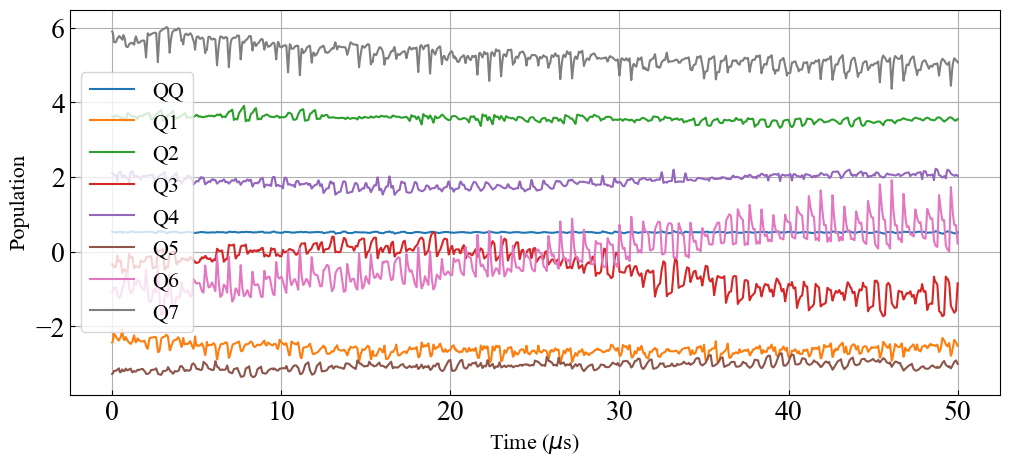

In [407]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))

# plt.plot(tlist, output.expect[0], label='central')
plt.plot(np.concatenate(t_list_list), np.concatenate(QQ), label='QQ')
plt.plot(np.concatenate(t_list_list), np.concatenate(Q1), label='Q1')
plt.plot(np.concatenate(t_list_list), np.concatenate(Q2), label='Q2')
plt.plot(np.concatenate(t_list_list), np.concatenate(Q3), label='Q3')
plt.plot(np.concatenate(t_list_list), np.concatenate(Q4), label='Q4')
plt.plot(np.concatenate(t_list_list), np.concatenate(Q5), label='Q5')
plt.plot(np.concatenate(t_list_list), np.concatenate(Q6), label='Q6')
plt.plot(np.concatenate(t_list_list), np.concatenate(Q7), label='Q7')

ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel('Population')
ax.tick_params(labelsize=20)
plt.grid()
plt.legend()